In [1]:
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn 
import bokeh 

In [2]:
daily_jhu_report_url_base = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/%s.csv"
def gather_daily_jhu_reports(date_rng):
    collected = pd.DataFrame()
    for date in date_rng:
        date_str = date.strftime("%m-%d-%Y")
#         print("Collecting data from: %s" % date_str)
        try:
            daily_report = pd.read_csv(daily_jhu_report_url_base % date_str)
            daily_report.insert(0, "Date", date)
            daily_report.rename(columns={
                'Country_Region':'Country/Region', 
                "Province_State": "Province/State", 
                "Last_Update": "Last Update",
                "Lat": "Latitude",
                "Long_": "Longitude"
            }, inplace=True)
            collected = pd.concat([collected, daily_report], axis=0, ignore_index=True)
        except:
            print("FAILED TO FETCH DATA FOR: %s" % date_str)
    return collected
report_data = gather_daily_jhu_reports(pd.date_range("1-22-2020", "03-25-2020").to_pydatetime())
report_data.to_csv("daily_jhu_report_data.csv", index=0)

/Users/kunal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [3]:
jhu_data = pd.read_csv("daily_jhu_report_data.csv")
selector = np.logical_or(
    jhu_data["Combined_Key"] == "Texas, US", 
    jhu_data["Province/State"] == "Texas"
)
selector = np.logical_or(selector, jhu_data["Province/State"] == "Texas")
jhu_tx_data = jhu_data[selector]
jhu_tx_data = jhu_tx_data.dropna()

In [4]:
jhu_tx_data.head(5)

,Active,Admin2,Combined_Key,Confirmed,Country/Region,Date,Deaths,FIPS,Last Update,Latitude,Longitude,Province/State,Recovered
7916,0.0,Dallas,"Dallas, Texas, US",131.0,US,2020-03-22,2.0,48113.0,3/22/20 23:45,32.766706,-96.777961,Texas,0.0
7917,0.0,Harris,"Harris, Texas, US",74.0,US,2020-03-22,1.0,48201.0,3/22/20 23:45,29.858649,-95.393395,Texas,0.0
7918,0.0,Travis,"Travis, Texas, US",62.0,US,2020-03-22,0.0,48453.0,3/22/20 23:45,30.334320,-97.785356,Texas,0.0
7919,0.0,Tarrant,"Tarrant, Texas, US",47.0,US,2020-03-22,1.0,48439.0,3/22/20 23:45,32.771438,-97.291016,Texas,0.0
7920,0.0,Bexar,"Bexar, Texas, US",46.0,US,2020-03-22,1.0,48029.0,3/22/20 23:45,29.449287,-98.520197,Texas,0.0


In [5]:
txlatmin = jhu_tx_data.Latitude.min()
txlatmax = jhu_tx_data.Latitude.max()
txlongmin = jhu_tx_data.Longitude.min()
txlongmax = jhu_tx_data.Longitude.max()
display(txlatmin, txlatmax,txlongmin,txlongmax)

26.14524221

36.27829105

-106.2363275

-93.74408813

In [7]:
dfw = plt.imread("largerarea.png")

In [8]:
latmin = 32.3304
latmax = 33.3607
longmin = -97.8001
longmax = -96.0354
BBox = (longmin, longmax, latmin, latmax)

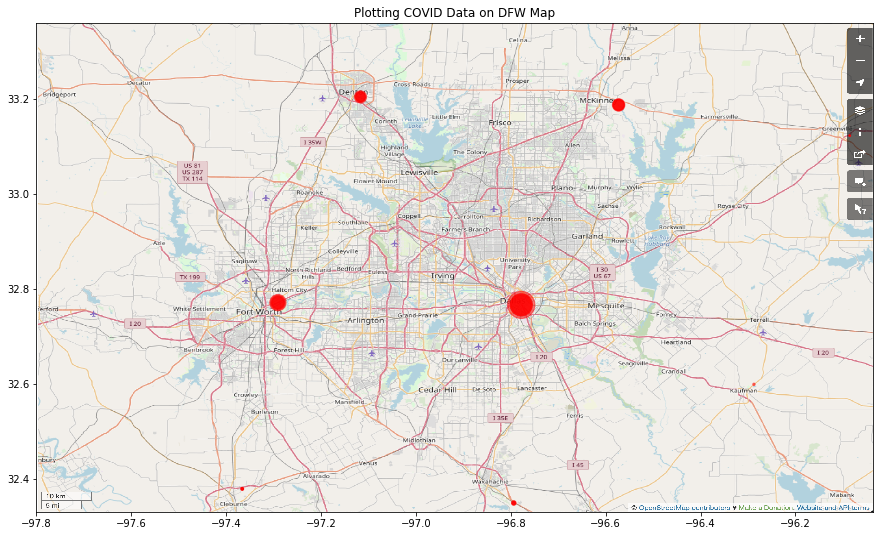

In [9]:
fig, ax = plt.subplots(figsize = (15,48))
ax.scatter(jhu_tx_data.Longitude, jhu_tx_data.Latitude, zorder=1, alpha= 0.5, c='r', s=jhu_tx_data['Confirmed']*3)
ax.set_title('Plotting COVID Data on DFW Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(dfw, zorder=0, extent = BBox, aspect= 'equal')

In [14]:
import plotly
import plotly.figure_factory as ff


confirmed_cases = jhu_tx_data['Confirmed'].tolist()
fips = jhu_tx_data['FIPS'].tolist()

colorscale = [
    'rgb(193, 193, 193)',
    'rgb(239,239,239)',
    'rgb(195, 196, 222)',
    'rgb(144,148,194)',
    'rgb(101,104,168)',
    'rgb(65, 53, 132)'
]

fig = ff.create_choropleth(
    fips=fips, values=confirmed_cases, scope=['TZ'],
    binning_endpoints=[5, 10, 25, 50, 90], colorscale=colorscale,
    county_outline={'color': 'rgb(255,255,255)', 'width': 0.5}, round_legend_values=True,
    legend_title='Confirmed COVID-19 Cases by County', title='Current COVID'
)
fig.layout.template = None
fig.show()

In [128]:
county = pd.read_csv('alldata.csv')

In [129]:
county.head()

,County,FIPS,Age,Total,Total_Male,Total_Female,NH_White_Total,NH_White_Male,NH_White_Female,NH_Black_Total,...,NH_Black_Female,NH_Asian_Total,NH_Asian_Male,NH_Asian_Female,NH_Other_Total,NH_Other_Male,NH_Other_Female,Hispanic_Total,Hispanic_Male,Hispanic_Female
0,STATE OF TEXAS,0,All Ages,28702243,14254981,14447262,12008303,5953354,6054949,3394972,...,1752264,1381899,677090,704809,629148,312300,316848,11287921,5669529,5618392
1,STATE OF TEXAS,0,< 1 Year,389277,198709,190568,114969,58905,56064,46083,...,22639,16580,8469,8111,17102,8778,8324,194543,99113,95430
2,STATE OF TEXAS,0,1 Years,395402,201725,193677,117408,60141,57267,46604,...,22959,16511,8468,8043,17255,8835,8420,197624,100636,96988
3,STATE OF TEXAS,0,2 Years,407861,208076,199785,122987,62939,60048,47786,...,23539,17479,8955,8524,17292,8840,8452,202317,103095,99222
4,STATE OF TEXAS,0,3 Years,417497,213195,204302,127819,65480,62339,48419,...,23920,17931,9220,8711,17230,8795,8435,206098,105201,100897


In [130]:
county['FIPS'] = county['FIPS'] + 48000

In [131]:
county.head()

,County,FIPS,Age,Total,Total_Male,Total_Female,NH_White_Total,NH_White_Male,NH_White_Female,NH_Black_Total,...,NH_Black_Female,NH_Asian_Total,NH_Asian_Male,NH_Asian_Female,NH_Other_Total,NH_Other_Male,NH_Other_Female,Hispanic_Total,Hispanic_Male,Hispanic_Female
0,STATE OF TEXAS,48000,All Ages,28702243,14254981,14447262,12008303,5953354,6054949,3394972,...,1752264,1381899,677090,704809,629148,312300,316848,11287921,5669529,5618392
1,STATE OF TEXAS,48000,< 1 Year,389277,198709,190568,114969,58905,56064,46083,...,22639,16580,8469,8111,17102,8778,8324,194543,99113,95430
2,STATE OF TEXAS,48000,1 Years,395402,201725,193677,117408,60141,57267,46604,...,22959,16511,8468,8043,17255,8835,8420,197624,100636,96988
3,STATE OF TEXAS,48000,2 Years,407861,208076,199785,122987,62939,60048,47786,...,23539,17479,8955,8524,17292,8840,8452,202317,103095,99222
4,STATE OF TEXAS,48000,3 Years,417497,213195,204302,127819,65480,62339,48419,...,23920,17931,9220,8711,17230,8795,8435,206098,105201,100897


In [132]:
county = county[~county.County.str.contains("STATE OF TEXAS")]
county = county[~county.Age.str.contains("All Ages")]
county = county[~county.Age.str.contains("<")]
# remove state of texas rows and unnecessary data

In [133]:
county.head()

,County,FIPS,Age,Total,Total_Male,Total_Female,NH_White_Total,NH_White_Male,NH_White_Female,NH_Black_Total,...,NH_Black_Female,NH_Asian_Total,NH_Asian_Male,NH_Asian_Female,NH_Other_Total,NH_Other_Male,NH_Other_Female,Hispanic_Total,Hispanic_Male,Hispanic_Female
99,ANDERSON COUNTY,48001,1 Years,604,299,305,280,140,140,117,...,57,3,1,2,67,32,35,137,66,71
100,ANDERSON COUNTY,48001,2 Years,589,305,284,281,147,134,117,...,53,3,2,1,51,27,24,137,65,72
101,ANDERSON COUNTY,48001,3 Years,586,311,275,284,147,137,113,...,49,4,2,2,52,31,21,133,67,66
102,ANDERSON COUNTY,48001,4 Years,584,311,273,285,151,134,110,...,53,3,2,1,43,24,19,143,77,66
103,ANDERSON COUNTY,48001,5 Years,556,281,275,280,141,139,100,...,49,3,1,2,37,13,24,136,75,61


In [134]:
county["Age"] = county["Age"].str.replace("Years", "")
county["Age"] = county["Age"].str.replace("+", "")

In [135]:
county["Age"] = pd.to_numeric(county["Age"]) # recast dtype to int

In [136]:
test = county

In [137]:
bins = [0,65,96]
names = ["<65","65+"]

In [138]:
test['AgeRange'] = pd.cut(test['Age'], bins, labels=names)

In [139]:
test.head()

,County,FIPS,Age,Total,Total_Male,Total_Female,NH_White_Total,NH_White_Male,NH_White_Female,NH_Black_Total,...,NH_Asian_Total,NH_Asian_Male,NH_Asian_Female,NH_Other_Total,NH_Other_Male,NH_Other_Female,Hispanic_Total,Hispanic_Male,Hispanic_Female,AgeRange
99,ANDERSON COUNTY,48001,1,604,299,305,280,140,140,117,...,3,1,2,67,32,35,137,66,71,<65
100,ANDERSON COUNTY,48001,2,589,305,284,281,147,134,117,...,3,2,1,51,27,24,137,65,72,<65
101,ANDERSON COUNTY,48001,3,586,311,275,284,147,137,113,...,4,2,2,52,31,21,133,67,66,<65
102,ANDERSON COUNTY,48001,4,584,311,273,285,151,134,110,...,3,2,1,43,24,19,143,77,66,<65
103,ANDERSON COUNTY,48001,5,556,281,275,280,141,139,100,...,3,1,2,37,13,24,136,75,61,<65


In [163]:
hold = test[['County', 'FIPS', 'AgeRange','Total']]

In [164]:
hold.Total.sum() # sanity check for state population

28312966

In [165]:
hold.head()

,County,FIPS,AgeRange,Total
99,ANDERSON COUNTY,48001,<65,604
100,ANDERSON COUNTY,48001,<65,589
101,ANDERSON COUNTY,48001,<65,586
102,ANDERSON COUNTY,48001,<65,584
103,ANDERSON COUNTY,48001,<65,556


In [178]:
total_county = hold[['County','AgeRange','Total', 'FIPS']].groupby(['County', 'FIPS']).sum()

In [179]:
total_county.head()

,,Total
County,FIPS,
ANDERSON COUNTY,48001,58374
ANDREWS COUNTY,48003,18415
ANGELINA COUNTY,48005,90479
ARANSAS COUNTY,48007,23509
ARCHER COUNTY,48009,9346


In [180]:
over65 = hold.loc[hold['AgeRange'] == '65+'].groupby(['County']).sum()

In [176]:
over65.head()

,FIPS,Total
County,,
ANDERSON COUNTY,1440030,8220
ANDREWS COUNTY,1440090,1749
ANGELINA COUNTY,1440150,13605
ARANSAS COUNTY,1440210,6165
ARCHER COUNTY,1440270,1778


In [181]:
vulnerable = pd.merge(over65, total_county, how='inner', on = 'County')

In [182]:
vulnerable.head()

,FIPS,Total_x,Total_y
County,,,
ANDERSON COUNTY,1440030,8220,58374
ANDREWS COUNTY,1440090,1749,18415
ANGELINA COUNTY,1440150,13605,90479
ARANSAS COUNTY,1440210,6165,23509
ARCHER COUNTY,1440270,1778,9346


In [184]:
vulnerable['pct_risk'] = vulnerable['Total_x'] / vulnerable['Total_y']

In [185]:
vulnerable.head()

,FIPS,Total_x,Total_y,pct_risk
County,,,,
ANDERSON COUNTY,1440030,8220,58374,0.140816
ANDREWS COUNTY,1440090,1749,18415,0.094977
ANGELINA COUNTY,1440150,13605,90479,0.150366
ARANSAS COUNTY,1440210,6165,23509,0.262240
ARCHER COUNTY,1440270,1778,9346,0.190242


In [186]:
vulnerable['FIPS'] = vulnerable['FIPS'] / 30

In [193]:
vulnerable['risk'] = vulnerable['pct_risk'] * 100

In [195]:
vulnerable_spots = vulnerable['risk'].tolist()
fips = vulnerable['FIPS'].tolist()

colorscale = [
    'rgb(193, 193, 193)',
    'rgb(239,239,239)',
    'rgb(195, 196, 222)',
    'rgb(144,148,194)',
    'rgb(101,104,168)',
    'rgb(65, 53, 132)'
]

fig = ff.create_choropleth(
    fips=fips, values=vulnerable_spots, scope=['TZ'],
    binning_endpoints=[0, 5, 10, 15,30], colorscale=colorscale,
    county_outline={'color': 'rgb(255,255,255)', 'width': 0.5}, round_legend_values=True,
    legend_title='Risk by County Based on Age Distribution (%)', title='COVID-19 Age Risk'
)
fig.layout.template = None
fig.show()